# Import Packages

In [135]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange

# Define Parameters and Models

In [363]:
SNR = 100
n_noise_realizations = 100
n_elements = 128
ob_weight = 100

tdata = np.linspace(0, 635, n_elements)
bdata = np.linspace(0, 635, n_elements)

n_lambdas = 51
lambdas = np.logspace(-4, 2, n_lambdas)

def noise(sd):
    return np.random.normal(0, sd, n_elements)

noise_sd = 1/SNR

# Define useful function

## Monoexponential functions

In [295]:
#Define the monoexponential model
def ME(t, c, tau):
    return c*np.exp(-t/tau)

def ME_tilde(lam):
    def ME(t, c, tau):
        function = c*np.exp(-t/tau)
        return np.append(function, [lam*c, lam*tau/ob_weight])
    return ME

#Define helper functions
def estimate_ME(data, lam=0):
    #Gives regularized NLLS estimate for the ME model given a data set and a lambda
    data_tilde = np.append(data, [0,0])
    
    (cest, Test), rcov = curve_fit(ME_tilde(lam), tdata, data_tilde)
    
    return cest, Test

def iterate_ME(c, tau, N, lambdas):
    #Iterates over a set of lambdas, gives bias, variance, and MSE of the regularized NLLS estimates
    n_lambdas = len(lambdas)
    bias = np.zeros((n_lambdas,2))
    variance = np.zeros((n_lambdas,2))
    MSE = np.zeros((n_lambdas,2))    
    p_true = [c,tau]
    
    underlying = ME(tdata, c, tau)
    
    for l in trange(n_lambdas):
        lam = lambdas[l]
        
        estimates = []
        for n in range(N):
            np.random.seed(n)
            data = underlying + noise(noise_sd)
            
            est = np.array(estimate_ME(data, lam))
            estimates.append(est)
        
        estimates = np.array(estimates)
        for p in range(2):
            pest = estimates[:,p]
            bias[l,p] = (pest-[p_true[p]]*N).sum()/N
            variance[l,p] = statistics.pvariance(pest)
            MSE[l,p] = bias[l,p]**2 + variance[l,p]
    return bias, variance, MSE

def min_lambda_ME(data, c, tau, lambdas, agg_arr = np.array([1,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c,tau])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_ME(data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda

def iterate_min_ME(c, tau, N, lambdas):
    #Uses the minimum error lambda to generate NLLS estimates
    bias = np.zeros(2)
    variance = np.zeros(2)
    MSE = np.zeros(2)    
    p_true = [c,tau]
    
    underlying = ME(tdata, c, tau)
        
    estimates = []
    min_lambdas = []
    for n in trange(N):
        np.random.seed(n)
        data = underlying + noise(noise_sd)
        est, lam = min_lambda_ME(data, c, tau, lambdas)

        estimates.append(est)
        min_lambdas.append(lam)
        
    estimates = np.array(estimates)
    for p in range(2):
        pest = estimates[:,p]
        bias[p] = (pest-[p_true[p]]*N).sum()/N
        variance[p] = statistics.pvariance(pest)
        MSE[p] = bias[p]**2 + variance[p]
    return bias, variance, MSE, min_lambdas

def J_ME(t, c, tau):
    #Returns the Jacobian for the ME model
    func1 = np.exp(-t/tau)
    func2 = ((c*t)/tau**2)*np.exp(-t/tau)
    jacobian = np.stack((func1, func2), axis=-1)
    
    return jacobian

def cov_ME(c, tau, noise_sd):
    #Returns the covariance matrix for the ME model
    jacobians = J_ME(tdata, c, tau).transpose()@J_ME(tdata, c, tau)
    cov = np.linalg.inv(jacobians)
    return noise_sd**2*cov

## Stretched Exponential Functions

In [315]:
#Define the stretched exponential model
def SE(t, alpha, tau):
    return np.exp(-np.power(t,alpha)/tau)

def SE_tilde(lam):
    def SE(t, alpha, tau):
        function = np.exp(-np.power(t,alpha)/tau)
        return np.append(function, [lam*alpha, lam*tau/ob_weight])
    return SE

#Define helper functions
def estimate_SE(data, lam=0):
    #Gives regularized NLLS estimate for the SE model given a data set and a lambda
    data_tilde = np.append(data, [0,0])
    
    (alphaEst, tauEst), rcov = curve_fit(SE_tilde(lam), tdata, data_tilde, gtol = 10**(-10))
    
    return alphaEst, tauEst

def iterate_SE(alpha, tau, N, lambdas):
    #Iterates over a set of lambdas, gives bias, variance, and MSE of the regularized NLLS estimates
    n_lambdas = len(lambdas)
    bias = np.zeros((n_lambdas,2))
    variance = np.zeros((n_lambdas,2))
    MSE = np.zeros((n_lambdas,2))    
    p_true = [alpha,tau]
    
    underlying = SE(tdata, alpha, tau)
    
    for l in trange(n_lambdas):
        lam = lambdas[l]
        
        estimates = []
        for n in range(N):
            np.random.seed(n)
            data = underlying + noise(noise_sd)
            
            est = np.array(estimate_SE(data, lam))
            estimates.append(est)
        
        estimates = np.array(estimates)
        for p in range(2):
            pest = estimates[:,p]
            bias[l,p] = (pest-[p_true[p]]*N).sum()/N
            variance[l,p] = statistics.pvariance(pest)
            MSE[l,p] = bias[l,p]**2 + variance[l,p]
    return bias, variance, MSE

def min_lambda_SE(data, alpha, tau, lambdas, agg_arr = np.array([1,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([alpha,tau])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_SE(data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_lambda = lambdas[min_error_idx]
    min_error_est = estimates[min_error_idx]
    return min_error_est, min_error_lambda

def iterate_min_SE(alpha, tau, N, lambdas):
    #Uses the minimum error lambda to generate NLLS estimates
    bias = np.zeros(2)
    variance = np.zeros(2)
    MSE = np.zeros(2)    
    p_true = [alpha,tau]
    
    underlying = SE(tdata, alpha, tau)
        
    estimates = []
    min_lambdas = []
    for n in trange(N):
        np.random.seed(n)
        data = underlying + noise(noise_sd)
        est, lam = min_lambda_SE(data, alpha, tau, lambdas)
        
        estimates.append(est)
        min_lambdas.append(lam)
        
    estimates = np.array(estimates)
    for p in range(2):
        pest = estimates[:,p]
        bias[p] = (pest-[p_true[p]]*N).sum()/N
        variance[p] = statistics.pvariance(pest)
        MSE[p] = bias[p]**2 + variance[p]
    return bias, variance, MSE, min_lambdas

def J_SE(t, alpha, tau):
    #Returns the Jacobian for the ME model
    func1 = -(1/tau)*np.power(t,alpha)*np.log(t)*np.exp(-np.power(t,alpha)/tau)
    func2 = (np.power(t,alpha)/tau**2)*np.exp(-np.power(t,alpha)/tau)
    jacobian = np.stack((func1, func2), axis=-1)
    
    return jacobian

def cov_SE(alpha, tau, noise_sd):
    #Returns the covariance matrix for the ME model
    jacobians = J_SE(tdata, alpha, tau).transpose()@J_SE(tdata, alpha, tau)
    cov = np.linalg.inv(jacobians)
    return noise_sd**2*cov

## Kurtosis functions

In [354]:
#Define the kurtosis model
def kurtosis(b, D, K):
    return np.exp(-b*D + (1/6)*(b**2)*(D**2)*K)

def kurt_tilde(lam):
    def kurtosis(b, D, K):
        function = np.exp(-b*D + (1/6)*(b**2)*(D**2)*K)
        return np.append(function, [lam*D, lam*K/ob_weight])
    return kurtosis

#Define helper functions
def estimate_kurt(data, lam=0):
    #Gives regularized NLLS estimate for the kurtosis model given a data set and a lambda
    data_tilde = np.append(data, [0,0])
    
    (DEst, KEst), rcov = curve_fit(kurt_tilde(lam), tdata, data_tilde, maxfev = 10000, p0 = [0.01,1])
    
    return DEst, KEst

def iterate_kurt(D, K, N, lambdas):
    #Iterates over a set of lambdas, gives bias, variance, and MSE of the regularized NLLS estimates
    n_lambdas = len(lambdas)
    bias = np.zeros((n_lambdas,2))
    variance = np.zeros((n_lambdas,2))
    MSE = np.zeros((n_lambdas,2))    
    p_true = [D,K]
    
    underlying = kurtosis(bdata, D, K)
    
    for l in trange(n_lambdas):
        lam = lambdas[l]
        
        estimates = []
        for n in range(N):
            np.random.seed(n)
            data = underlying + noise(noise_sd)
            
            est = np.array(estimate_kurt(data, lam))
            estimates.append(est)
        
        estimates = np.array(estimates)
        for p in range(2):
            pest = estimates[:,p]
            bias[l,p] = (pest-[p_true[p]]*N).sum()/N
            variance[l,p] = statistics.pvariance(pest)
            MSE[l,p] = bias[l,p]**2 + variance[l,p]
    return bias, variance, MSE

def min_lambda_kurt(data, D, K, lambdas, agg_arr = np.array([1,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([D,K])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_kurt(data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_lambda = lambdas[min_error_idx]
    min_error_est = estimates[min_error_idx]
    return min_error_est, min_error_lambda

def iterate_min_kurt(D, K, N, lambdas):
    #Uses the minimum error lambda to generate NLLS estimates
    bias = np.zeros(2)
    variance = np.zeros(2)
    MSE = np.zeros(2)    
    p_true = [D,K]
    
    underlying = kurtosis(bdata, D, K)
        
    estimates = []
    min_lambdas = []
    for n in trange(N):
        np.random.seed(n)
        data = underlying + noise(noise_sd)
        est, lam = min_lambda_kurt(data, D, K, lambdas)
        
        estimates.append(est)
        min_lambdas.append(lam)
        
    estimates = np.array(estimates)
    for p in range(2):
        pest = estimates[:,p]
        bias[p] = (pest-[p_true[p]]*N).sum()/N
        variance[p] = statistics.pvariance(pest)
        MSE[p] = bias[p]**2 + variance[p]
    return bias, variance, MSE, min_lambdas

def J_kurt(b, D, K):
    #Returns the Jacobian for the ME model
    func1 = (-b + (1/3)*(b**2)*D*K)*np.exp(-b*D + (1/6)*(b**2)*(D**2)*K)
    func2 = (1/6)*(b**2)*(D**2)*np.exp(-b*D + (1/6)*(b**2)*(D**2)*K)
    jacobian = np.stack((func1, func2), axis=-1)
    
    return jacobian

def cov_kurt(D, K, noise_sd):
    #Returns the covariance matrix for the ME model
    jacobians = J_kurt(bdata, D, K).transpose()@J_kurt(bdata, D, K)
    cov = np.linalg.inv(jacobians)
    return noise_sd**2*cov

# Display sample data for each model

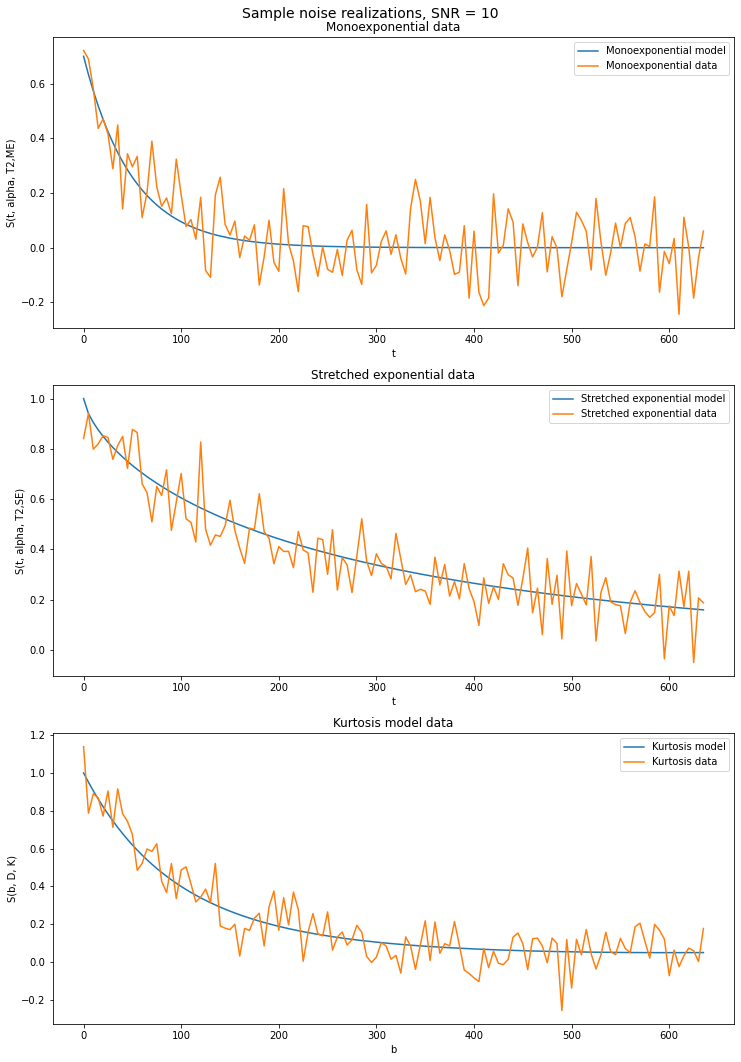

In [353]:
ME_mod = ME(tdata, 0.7, 50)
ME_data = ME_mod + noise(noise_sd)

SE_mod = SE(tdata, 0.7, 50)
SE_data = SE_mod + noise(noise_sd)

kurt_mod = kurtosis(bdata, 0.01, 0.5)
kurt_data = kurt_mod + noise(noise_sd)

fig, ax = plt.subplots(3, figsize = (10.4, 15), tight_layout=True)
fig.suptitle('Sample noise realizations, SNR = %s' % SNR, size = 14)
ax[0].plot(tdata, ME_mod, label = 'Monoexponential model')
ax[0].plot(tdata, ME_data, label = 'Monoexponential data')
ax[0].set_title('Monoexponential data')
ax[0].set_ylabel('S(t, alpha, T2,ME)')
ax[0].set_xlabel('t')
ax[0].legend()

ax[1].plot(tdata, SE_mod, label = 'Stretched exponential model')
ax[1].plot(tdata, SE_data, label = 'Stretched exponential data')
ax[1].set_title('Stretched exponential data')
ax[1].set_ylabel('S(t, alpha, T2,SE)')
ax[1].set_xlabel('t')
ax[1].legend()

ax[2].plot(bdata, kurt_mod, label = 'Kurtosis model')
ax[2].plot(bdata, kurt_data, label = 'Kurtosis data')
ax[2].set_title('Kurtosis model data')
ax[2].set_ylabel('S(b, D, K)')
ax[2].set_xlabel('b')
ax[2].legend()

plt.show()

# Define functions for GCV

## Monoexponential GCV

In [53]:
def get_GCV_ME(GCV_data, GCV_lam):

    cGCV, TGCV = estimate_ME(GCV_data, GCV_lam)
    
    GCVjacobian = J_ME(tdata, cGCV, TGCV)
    GCV_residual = ((ME(tdata, cGCV, TGCV)-GCV_data)**2).sum()
    wmat = np.array([[1,0],[0,1/ob_weight]])
    
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda_ME(GCV_data, GCVlambdas):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV_ME(GCV_data, GCVlam))
    outLam = GCVlambdas[np.argmin(GCV_values)]
    return outLam, GCV_values

def iterate_GCV_ME(c, tau, N, lambdas):
    bias = np.zeros(2)
    variance = np.zeros(2)
    MSE = np.zeros(2)    
    p_true = [c,tau]
    
    underlying = ME(tdata, c, tau)
        
    estimates = []
    GCVlambdas = []
    for n in trange(N):
        np.random.seed(n)
        data = underlying + noise(noise_sd)
        lam, GCV_values = GCV_lambda_ME(data, lambdas)
        
        est = np.array(estimate_ME(data, lam))
        estimates.append(est)
        GCVlambdas.append(lam)
        
    estimates = np.array(estimates)
    for p in range(2):
        pest = estimates[:,p]
        bias[p] = (pest-[p_true[p]]*N).sum()/N
        variance[p] = statistics.pvariance(pest)
        MSE[p] = bias[p]**2 + variance[p]
    return bias, variance, MSE, GCVlambdas

## Stretched Exponential GCV

In [329]:
def get_GCV_SE(GCV_data, GCV_lam):

    alphaGCV, TGCV = estimate_SE(GCV_data, GCV_lam)
    
    GCVjacobian = J_SE(tdata, alphaGCV, TGCV)
    GCV_residual = ((SE(tdata, alphaGCV, TGCV)-GCV_data)**2).sum()
    wmat = np.array([[1,0],[0,1/ob_weight]])
    
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda_SE(GCV_data, GCVlambdas):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV_SE(GCV_data, GCVlam))
    outLam = GCVlambdas[np.argmin(GCV_values)]
    return outLam, GCV_values

def iterate_GCV_SE(alpha, tau, N, lambdas):
    bias = np.zeros(2)
    variance = np.zeros(2)
    MSE = np.zeros(2)    
    p_true = [alpha,tau]
    
    underlying = SE(tdata, alpha, tau)
        
    estimates = []
    GCVlambdas = []
    for n in trange(N):
        np.random.seed(n)
        data = underlying + noise(noise_sd)
        lam, GCV_values = GCV_lambda_SE(data, lambdas)
        
        est = np.array(estimate_SE(data, lam))
        estimates.append(est)
        GCVlambdas.append(lam)
        
    estimates = np.array(estimates)
    for p in range(2):
        pest = estimates[:,p]
        bias[p] = (pest-[p_true[p]]*N).sum()/N
        variance[p] = statistics.pvariance(pest)
        MSE[p] = bias[p]**2 + variance[p]
    return bias, variance, MSE, GCVlambdas

## Kurtosis GCV

In [357]:
def get_GCV_kurt(GCV_data, GCV_lam):

    DGCV, KGCV = estimate_kurt(GCV_data, GCV_lam)
    
    GCVjacobian = J_kurt(bdata, DGCV, KGCV)
    GCV_residual = ((kurtosis(bdata, DGCV, KGCV)-GCV_data)**2).sum()
    wmat = np.array([[1,0],[0,1/ob_weight]])
    
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda_kurt(GCV_data, GCVlambdas):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV_kurt(GCV_data, GCVlam))
    outLam = GCVlambdas[np.argmin(GCV_values)]
    return outLam, GCV_values

def iterate_GCV_kurt(D, K, N, lambdas):
    bias = np.zeros(2)
    variance = np.zeros(2)
    MSE = np.zeros(2)    
    p_true = [D,K]
    
    underlying = kurtosis(bdata, D, K)
        
    estimates = []
    GCVlambdas = []
    for n in trange(N):
        np.random.seed(n)
        data = underlying + noise(noise_sd)
        lam, GCV_values = GCV_lambda_kurt(data, lambdas)
        
        est = np.array(estimate_kurt(data, lam))
        estimates.append(est)
        GCVlambdas.append(lam)
        
    estimates = np.array(estimates)
    for p in range(2):
        pest = estimates[:,p]
        bias[p] = (pest-[p_true[p]]*N).sum()/N
        variance[p] = statistics.pvariance(pest)
        MSE[p] = bias[p]**2 + variance[p]
    return bias, variance, MSE, GCVlambdas

# Test GCV

## Monoexponential Model

In [301]:
c = 0.7
T = 50

start_time = time.time()
ME_bias, ME_variance, ME_MSE = iterate_ME(c, T, n_noise_realizations, lambdas)
GCV_ME_bias, GCV_ME_variance, GCV_ME_MSE, ME_GCVlambdas = iterate_GCV_ME(c, T, n_noise_realizations, lambdas)
min_ME_bias, min_ME_variance, min_ME_MSE,  ME_min_lambdas = iterate_min_ME(c, T, n_noise_realizations, lambdas)
print(time.time()-start_time, 'seconds')

 75%|█████████████████████████████████████████████████████████████                     | 38/51 [00:01<00:00, 15.65it/s]<ipython-input-295-7b232f0db3b1>:7: RuntimeWarning: overflow encountered in exp
  function = c*np.exp(-t/tau)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.08it/s]

8.33101487159729 seconds


### Plot GCV data from monoexponential model

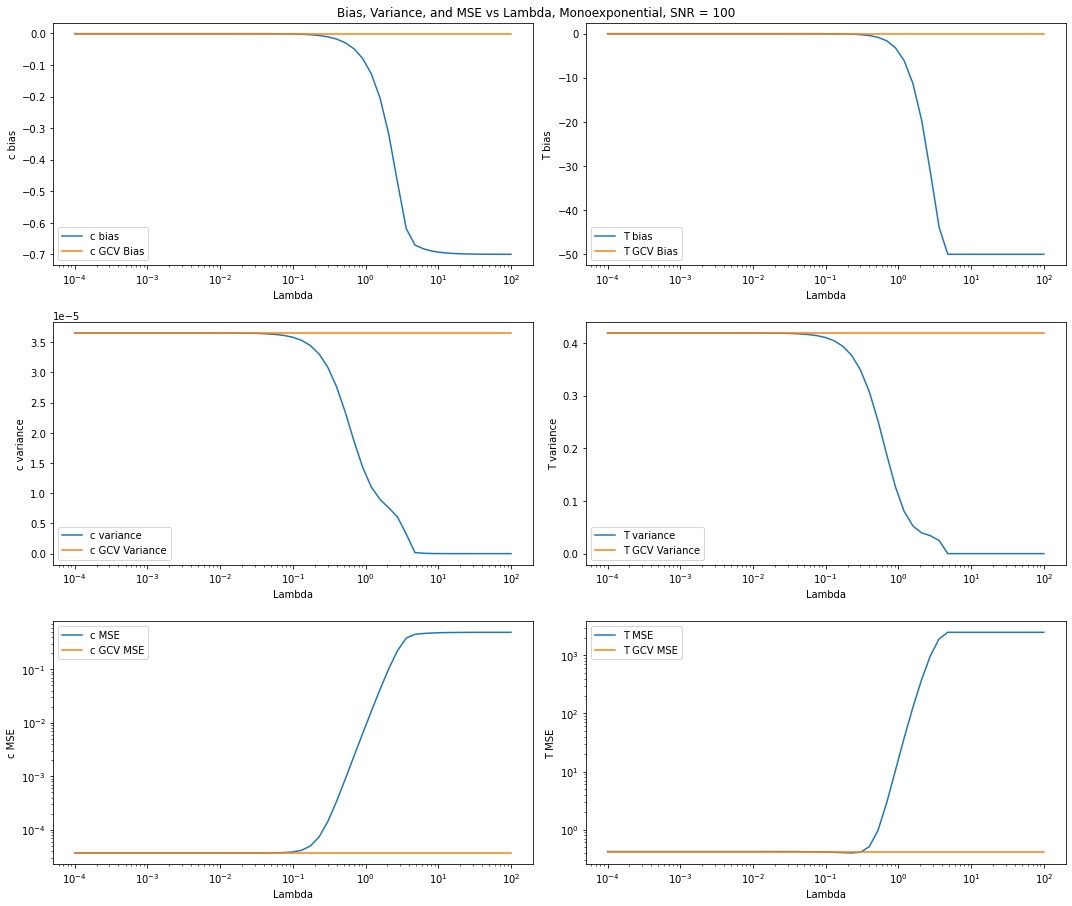

In [302]:
figure, axis = plt.subplots(3, 2, figsize=(15, 12.8),tight_layout=True)

plabels = ['c','T']

figure.suptitle('Bias, Variance, and MSE vs Lambda, Monoexponential, SNR = %s' % SNR)
for p in range(2):
    axis[0,p].semilogx(lambdas, ME_bias[:,p], label='%s bias'%plabels[p])
    axis[0,p].semilogx(lambdas, [GCV_ME_bias[p]]*n_lambdas, label = '%s GCV Bias'%plabels[p])
    axis[0,p].set_ylabel('%s bias'%plabels[p])
    
    axis[1,p].semilogx(lambdas, ME_variance[:,p], label='%s variance'%plabels[p])
    axis[1,p].semilogx(lambdas, [GCV_ME_variance[p]]*n_lambdas, label = '%s GCV Variance'%plabels[p])
    axis[1,p].set_ylabel('%s variance'%plabels[p])
    
    axis[2,p].loglog(lambdas, ME_MSE[:,p], label='%s MSE'%plabels[p])
    axis[2,p].loglog(lambdas, [GCV_ME_MSE[p]]*n_lambdas, label = '%s GCV MSE'%plabels[p])
    axis[2,p].set_ylabel('%s MSE'%plabels[p])
for i in range(3):
    for j in range(2):
        axis[i,j].legend()
        axis[i,j].set_xlabel('Lambda')

plt.show()

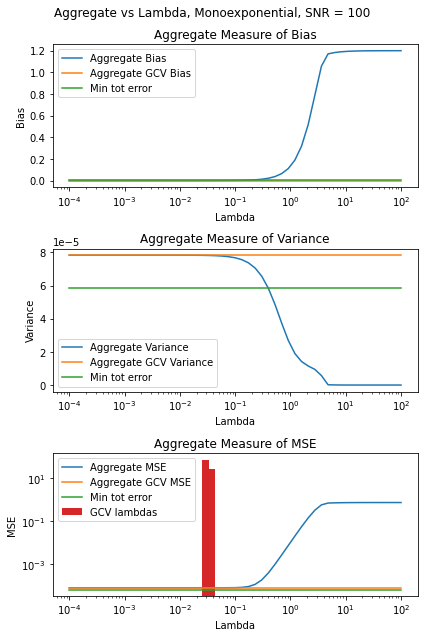

In [303]:
wgt = np.array([1,1/ob_weight])

agg_ME_bias = np.absolute(ME_bias).dot(wgt)
agg_ME_variance = np.array(ME_variance).dot(wgt**2)
agg_ME_MSE = np.array(ME_MSE).dot(wgt**2)

agg_GCV_ME_bias = np.absolute(GCV_ME_bias).dot(wgt)
agg_GCV_ME_variance = np.array(GCV_ME_variance).dot(wgt**2)
agg_GCV_ME_MSE = np.array(GCV_ME_MSE).dot(wgt**2)

agg_min_ME_bias = np.absolute(min_ME_bias).dot(wgt)
agg_min_ME_variance = np.array(min_ME_variance).dot(wgt**2)
agg_min_ME_MSE = np.array(min_ME_MSE).dot(wgt**2)

fig, ax = plt.subplots(3,1,figsize=(6,9), tight_layout=True)
fig.suptitle('Aggregate vs Lambda, Monoexponential, SNR = %s' % SNR)
ax[0].semilogx(lambdas, agg_ME_bias, label='Aggregate Bias')
ax[0].semilogx(lambdas, [agg_GCV_ME_bias]*n_lambdas, label = 'Aggregate GCV Bias')
ax[0].semilogx(lambdas, [agg_min_ME_bias]*n_lambdas, label = 'Min tot error')
ax[0].set_ylabel('Bias')
ax[0].set_xlabel('Lambda')
ax[0].set_title('Aggregate Measure of Bias')
ax[0].legend()

ax[1].semilogx(lambdas, agg_ME_variance, label='Aggregate Variance')
ax[1].semilogx(lambdas, [agg_GCV_ME_variance]*n_lambdas, label = 'Aggregate GCV Variance')
ax[1].semilogx(lambdas, [agg_min_ME_variance]*n_lambdas, label = 'Min tot error')
ax[1].set_ylabel('Variance')
ax[1].set_xlabel('Lambda')
ax[1].set_title('Aggregate Measure of Variance')
ax[1].legend()

ax[2].loglog(lambdas, agg_ME_MSE, label='Aggregate MSE')
ax[2].loglog(lambdas, [agg_GCV_ME_MSE]*n_lambdas, label = 'Aggregate GCV MSE')
ax[2].loglog(lambdas, [agg_min_ME_MSE]*n_lambdas, label = 'Min tot error')
ax[2].hist(ME_GCVlambdas, bins = lambdas, label = 'GCV lambdas')
ax[2].set_ylabel('MSE')
ax[2].set_xlabel('Lambda')
ax[2].set_title('Aggregate Measure of MSE')
ax[2].legend()

plt.show()

## Stretched Exponential Model

In [304]:
alpha = 0.7
T = 50

start_time = time.time()
SE_bias, SE_variance, SE_MSE = iterate_SE(alpha, T, n_noise_realizations, lambdas)
GCV_SE_bias, GCV_SE_variance, GCV_SE_MSE, SE_GCVlambdas = iterate_GCV_SE(alpha, T, n_noise_realizations, lambdas)
min_SE_bias, min_SE_variance, min_SE_MSE,  SE_min_lambdas = iterate_min_SE(alpha, T, n_noise_realizations, lambdas)
print(time.time()-start_time, 'seconds')

  0%|                                                                                           | 0/51 [00:00<?, ?it/s]<ipython-input-259-e3482ea4d836>:7: RuntimeWarning: divide by zero encountered in power
  function = np.exp(-np.power(t,alpha)/tau)
 96%|██████████████████████████████████████████████████████████████████████████████▊   | 49/51 [00:04<00:00, 16.94it/s]<ipython-input-259-e3482ea4d836>:7: RuntimeWarning: overflow encountered in exp
  function = np.exp(-np.power(t,alpha)/tau)
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-259-e3482ea4d836>:94: RuntimeWarning: divide by zero encountered in log
  func1 = -(1/tau)*np.power(t,alpha)*np.log(t)*np.exp(-np.power(t,alpha)/tau)
<ipython-input-259-e3482ea4d836>:94: RuntimeWarning: invalid value encountered in multiply
  func1 = -(1/tau)*np.power(t,alpha)*np.log(t)*np.exp(-np.power(t,alpha)/tau)
<ipython-input-259-e3482ea4d836>:94: RuntimeWarning: 

13.53085994720459 seconds


### Plot GCV data from stretched exponential model

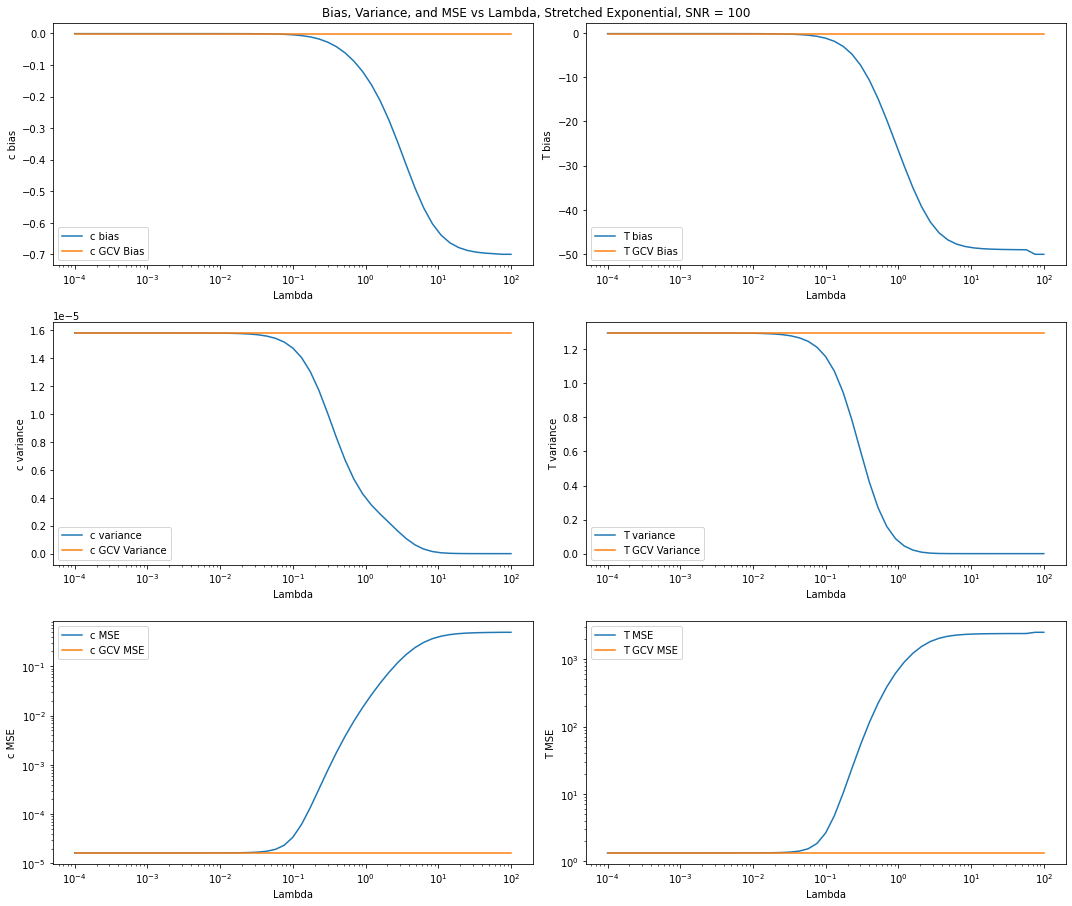

In [305]:
figure, axis = plt.subplots(3, 2, figsize=(15, 12.8),tight_layout=True)

plabels = ['c','T']

figure.suptitle('Bias, Variance, and MSE vs Lambda, Stretched Exponential, SNR = %s' % SNR)
for p in range(2):
    axis[0,p].semilogx(lambdas, SE_bias[:,p], label='%s bias'%plabels[p])
    axis[0,p].semilogx(lambdas, [GCV_SE_bias[p]]*n_lambdas, label = '%s GCV Bias'%plabels[p])
    axis[0,p].set_ylabel('%s bias'%plabels[p])
    
    axis[1,p].semilogx(lambdas, SE_variance[:,p], label='%s variance'%plabels[p])
    axis[1,p].semilogx(lambdas, [GCV_SE_variance[p]]*n_lambdas, label = '%s GCV Variance'%plabels[p])
    axis[1,p].set_ylabel('%s variance'%plabels[p])
    
    axis[2,p].loglog(lambdas, SE_MSE[:,p], label='%s MSE'%plabels[p])
    axis[2,p].loglog(lambdas, [GCV_SE_MSE[p]]*n_lambdas, label = '%s GCV MSE'%plabels[p])
    axis[2,p].set_ylabel('%s MSE'%plabels[p])
for i in range(3):
    for j in range(2):
        axis[i,j].legend()
        axis[i,j].set_xlabel('Lambda')

plt.show()

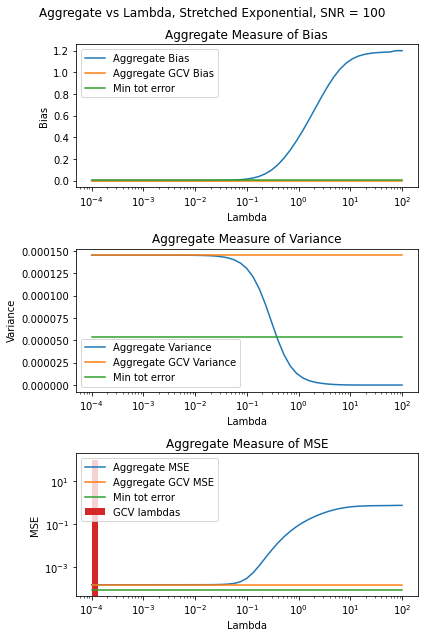

In [306]:
wgt = np.array([1,1/ob_weight])

agg_SE_bias = np.absolute(SE_bias).dot(wgt)
agg_SE_variance = np.array(SE_variance).dot(wgt**2)
agg_SE_MSE = np.array(SE_MSE).dot(wgt**2)

agg_GCV_SE_bias = np.absolute(GCV_SE_bias).dot(wgt)
agg_GCV_SE_variance = np.array(GCV_SE_variance).dot(wgt**2)
agg_GCV_SE_MSE = np.array(GCV_SE_MSE).dot(wgt**2)

agg_min_SE_bias = np.absolute(min_SE_bias).dot(wgt)
agg_min_SE_variance = np.array(min_SE_variance).dot(wgt**2)
agg_min_SE_MSE = np.array(min_SE_MSE).dot(wgt**2)

fig, ax = plt.subplots(3,1,figsize=(6,9), tight_layout=True)
fig.suptitle('Aggregate vs Lambda, Stretched Exponential, SNR = %s' % SNR)
ax[0].semilogx(lambdas, agg_SE_bias, label='Aggregate Bias')
ax[0].semilogx(lambdas, [agg_GCV_SE_bias]*n_lambdas, label = 'Aggregate GCV Bias')
ax[0].semilogx(lambdas, [agg_min_SE_bias]*n_lambdas, label = 'Min tot error')
ax[0].set_ylabel('Bias')
ax[0].set_xlabel('Lambda')
ax[0].set_title('Aggregate Measure of Bias')
ax[0].legend()

ax[1].semilogx(lambdas, agg_SE_variance, label='Aggregate Variance')
ax[1].semilogx(lambdas, [agg_GCV_SE_variance]*n_lambdas, label = 'Aggregate GCV Variance')
ax[1].semilogx(lambdas, [agg_min_SE_variance]*n_lambdas, label = 'Min tot error')
ax[1].set_ylabel('Variance')
ax[1].set_xlabel('Lambda')
ax[1].set_title('Aggregate Measure of Variance')
ax[1].legend()

ax[2].loglog(lambdas, agg_SE_MSE, label='Aggregate MSE')
ax[2].loglog(lambdas, [agg_GCV_SE_MSE]*n_lambdas, label = 'Aggregate GCV MSE')
ax[2].loglog(lambdas, [agg_min_SE_MSE]*n_lambdas, label = 'Min tot error')
ax[2].hist(SE_GCVlambdas, bins = lambdas, label = 'GCV lambdas')
ax[2].set_ylabel('MSE')
ax[2].set_xlabel('Lambda')
ax[2].set_title('Aggregate Measure of MSE')
ax[2].legend()

plt.show()

## Kurtosis Model

In [355]:
estimate_kurt(kurt_data, lam=0)

(0.009741897927502054, 0.500477340705604)

In [364]:
D = 0.01
K = 1
lambdas = np.logspace(-4,5, n_lambdas)

start_time = time.time()
kurt_bias, kurt_variance, kurt_MSE = iterate_kurt(D, K, n_noise_realizations, lambdas)
GCV_kurt_bias, GCV_kurt_variance, GCV_kurt_MSE, kurt_GCVlambdas = iterate_GCV_kurt(D, K, n_noise_realizations, lambdas)
min_kurt_bias, min_kurt_variance, min_kurt_MSE,  kurt_min_lambdas = iterate_min_kurt(D, K, n_noise_realizations, lambdas)
print(time.time()-start_time, 'seconds')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.86it/s]

12.191243410110474 seconds


### Plot GCV data from kurt model

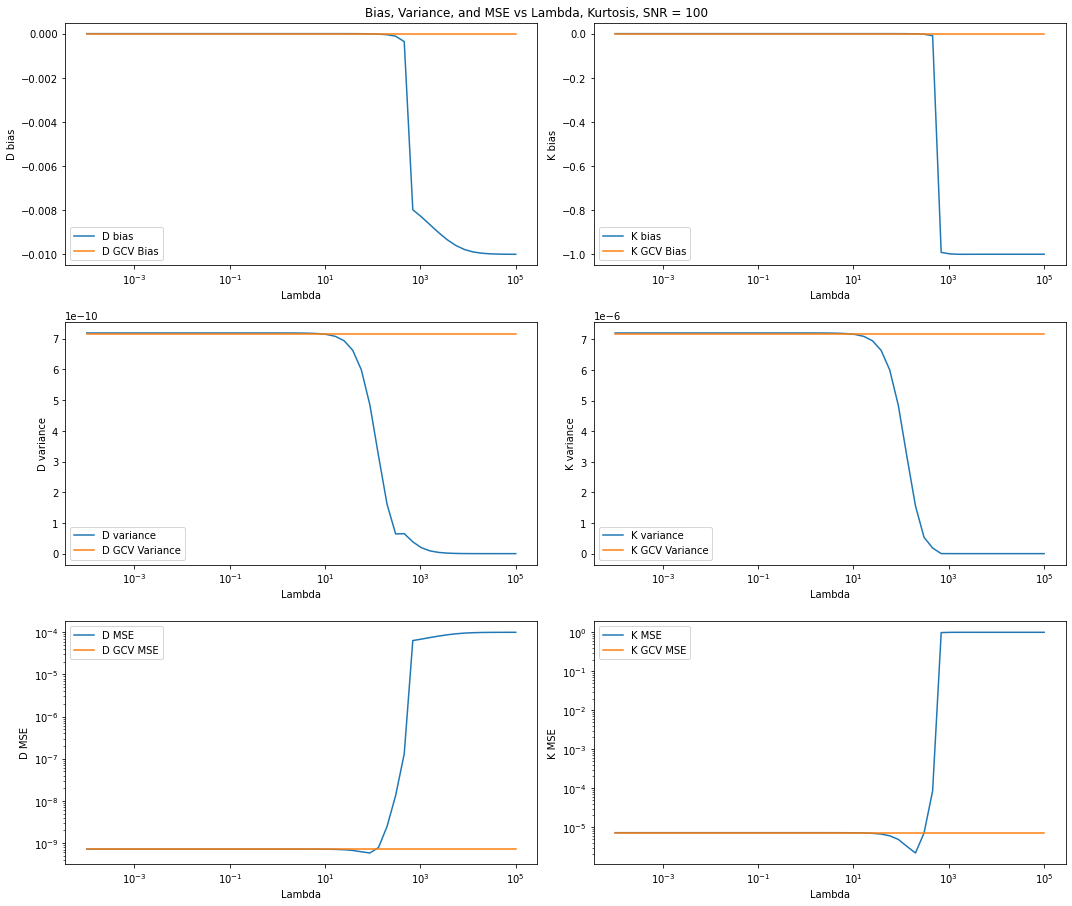

In [365]:
figure, axis = plt.subplots(3, 2, figsize=(15, 12.8),tight_layout=True)

plabels = ['D','K']

figure.suptitle('Bias, Variance, and MSE vs Lambda, Kurtosis, SNR = %s' % SNR)
for p in range(2):
    axis[0,p].semilogx(lambdas, kurt_bias[:,p], label='%s bias'%plabels[p])
    axis[0,p].semilogx(lambdas, [GCV_kurt_bias[p]]*n_lambdas, label = '%s GCV Bias'%plabels[p])
    axis[0,p].set_ylabel('%s bias'%plabels[p])
    
    axis[1,p].semilogx(lambdas, kurt_variance[:,p], label='%s variance'%plabels[p])
    axis[1,p].semilogx(lambdas, [GCV_kurt_variance[p]]*n_lambdas, label = '%s GCV Variance'%plabels[p])
    axis[1,p].set_ylabel('%s variance'%plabels[p])
    
    axis[2,p].loglog(lambdas, kurt_MSE[:,p], label='%s MSE'%plabels[p])
    axis[2,p].loglog(lambdas, [GCV_kurt_MSE[p]]*n_lambdas, label = '%s GCV MSE'%plabels[p])
    axis[2,p].set_ylabel('%s MSE'%plabels[p])
for i in range(3):
    for j in range(2):
        axis[i,j].legend()
        axis[i,j].set_xlabel('Lambda')

plt.show()

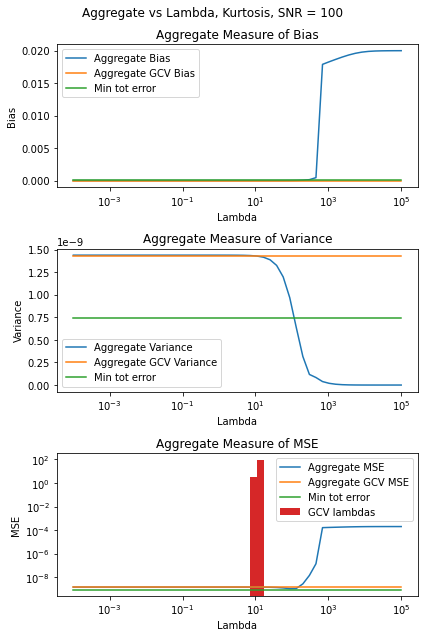

In [366]:
wgt = np.array([1,1/ob_weight])

agg_kurt_bias = np.absolute(kurt_bias).dot(wgt)
agg_kurt_variance = np.array(kurt_variance).dot(wgt**2)
agg_kurt_MSE = np.array(kurt_MSE).dot(wgt**2)

agg_GCV_kurt_bias = np.absolute(GCV_kurt_bias).dot(wgt)
agg_GCV_kurt_variance = np.array(GCV_kurt_variance).dot(wgt**2)
agg_GCV_kurt_MSE = np.array(GCV_kurt_MSE).dot(wgt**2)

agg_min_kurt_bias = np.absolute(min_kurt_bias).dot(wgt)
agg_min_kurt_variance = np.array(min_kurt_variance).dot(wgt**2)
agg_min_kurt_MSE = np.array(min_kurt_MSE).dot(wgt**2)

fig, ax = plt.subplots(3,1,figsize=(6,9), tight_layout=True)
fig.suptitle('Aggregate vs Lambda, Kurtosis, SNR = %s' % SNR)
ax[0].semilogx(lambdas, agg_kurt_bias, label='Aggregate Bias')
ax[0].semilogx(lambdas, [agg_GCV_kurt_bias]*n_lambdas, label = 'Aggregate GCV Bias')
ax[0].semilogx(lambdas, [agg_min_kurt_bias]*n_lambdas, label = 'Min tot error')
ax[0].set_ylabel('Bias')
ax[0].set_xlabel('Lambda')
ax[0].set_title('Aggregate Measure of Bias')
ax[0].legend()

ax[1].semilogx(lambdas, agg_kurt_variance, label='Aggregate Variance')
ax[1].semilogx(lambdas, [agg_GCV_kurt_variance]*n_lambdas, label = 'Aggregate GCV Variance')
ax[1].semilogx(lambdas, [agg_min_kurt_variance]*n_lambdas, label = 'Min tot error')
ax[1].set_ylabel('Variance')
ax[1].set_xlabel('Lambda')
ax[1].set_title('Aggregate Measure of Variance')
ax[1].legend()

ax[2].loglog(lambdas, agg_kurt_MSE, label='Aggregate MSE')
ax[2].loglog(lambdas, [agg_GCV_kurt_MSE]*n_lambdas, label = 'Aggregate GCV MSE')
ax[2].loglog(lambdas, [agg_min_kurt_MSE]*n_lambdas, label = 'Min tot error')
ax[2].hist(kurt_GCVlambdas, bins = lambdas, label = 'GCV lambdas')
ax[2].set_ylabel('MSE')
ax[2].set_xlabel('Lambda')
ax[2].set_title('Aggregate Measure of MSE')
ax[2].legend()

plt.show()